### Load FashionMNIST dataset

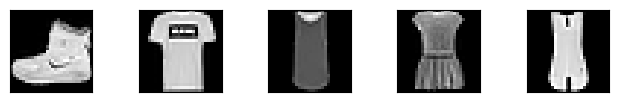

In [1]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)
import torchvision
import torchvision.transforms as transforms
import tqdm
import matplotlib.pyplot as plt


def load_fashion_mnist_data(root_path='./data', batch_size=4):
    transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))]
    )

    train_dataset = torchvision.datasets.FashionMNIST(root=root_path, train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    test_dataset = torchvision.datasets.FashionMNIST(root=root_path, train=False, download=True, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader, train_dataset, test_dataset


def plot_fashsion_mnist_images():
    _, _, train_dataset, _ = load_fashion_mnist_data()

    # get first x items
    no = 5
    images = [train_dataset.__getitem__(i)[0].permute(1,2,0) for i in range(0, no)]

    for i in range(no):
        plt.subplot(1, no, i+1)
        plt.tight_layout()
        plt.imshow(images[i], cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
    plt.show()

plot_fashsion_mnist_images()

### Training and evaluation methods

In [2]:
import torch
from typing import Callable
from torch.optim import Optimizer
from torch.utils.data import DataLoader
import torch.nn as nn

def train_model(
    model: nn.Module, loss_fn: Callable, optimizer: Optimizer, train_data_loader: DataLoader, 
    epoch: int, batch_size: int = 4, epochs: int = 10, device: torch.device = 'cpu'
):
    # training mode
    model.train()

    running_loss = []
    running_accuracy = []
    for imgs, targets in tqdm.tqdm(train_data_loader, desc=f'Training iteration {epoch + 1}'):
        imgs, targets = imgs.to(device=device), targets.to(device=device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(imgs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss.append(loss.item())

        # Calculate the Accuracy 
        max_outputs = torch.max(outputs, dim=1).indices
        accuracy = (max_outputs.detach() == targets.detach()).to(dtype=torch.float32).mean()
        running_accuracy.append(accuracy)
    
    return torch.mean(torch.as_tensor(running_loss)), torch.mean(torch.as_tensor(running_accuracy))


def eval_model(
    model: nn.Module, loss_fn: Callable, val_data_loader: DataLoader, 
    epoch: int, batch_size: int = 4, device: torch.device = 'cpu'
):
    # evaluation mode
    model.eval()

    with torch.no_grad():
        running_loss = []
        running_accuracy = []
        for imgs, targets in tqdm.tqdm(val_data_loader, desc=f'Evaluation iteration {epoch + 1}'):
            imgs, targets = imgs.to(device=device), targets.to(device=device)

            # forward + backward + optimize
            outputs = model(imgs)
            loss = loss_fn(outputs, targets)

            # print statistics
            running_loss.append(loss.item())

            # Calculate the Accuracy 
            max_outputs = torch.max(outputs, dim=1).indices
            accuracy = (max_outputs.detach() == targets.detach()).to(dtype=torch.float32).mean()
            running_accuracy.append(accuracy)
    
    return torch.mean(torch.as_tensor(running_loss)), torch.mean(torch.as_tensor(running_accuracy))

# combine train and evaluation phase
def operate(model: nn.Module, loss_fn: Callable, optimizer: Optimizer,
            train_data_loader: DataLoader, test_data_loader: DataLoader, 
            batch_size: int = 4, epochs: int = 10):
    
    t_losses, t_accs, e_losses, e_accs = [], [], [], []
    for epoch in range(epochs):
        t_loss, t_acc = train_model(model=model, loss_fn=loss_fn, optimizer=optimizer, train_data_loader=train_data_loader, epoch=epoch, batch_size=batch_size, epochs=epochs)
        t_losses.append(t_loss)
        t_accs.append(t_acc)

        e_loss, e_acc = eval_model(model=model, loss_fn=loss_fn, val_data_loader=test_data_loader, epoch=epoch, batch_size=batch_size)
        e_losses.append(e_loss)
        e_accs.append(e_acc)

        print(f'Training epoch {epoch + 1} finished with loss: {t_loss} and accuracy {t_acc}')
        print(f'Eval epoch {epoch + 1} finished with loss: {e_loss} and accuracy {e_acc}')
    
    return t_losses, t_accs, e_losses, e_accs


### Set hyperparameters

In [3]:
batch_size = 4
train_data_loader, test_data_loader, _, _ = load_fashion_mnist_data(batch_size=batch_size)

epochs = 5

# method to count the number of parameters 
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Linear model 

In [4]:
import torch.nn as nn

# Linear Model with Batch Norm
class LinearLayerModel_BatchNorm(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 32), 
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
    
    def forward(self, imgs):
        imgs = imgs.reshape(imgs.shape[0], -1)

        return self.model(imgs)

### Convolutional model

In [5]:
# Convolutional Model with Batch Norm   
class ConvLayerModel_BatchNorm(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            # fully connected layer
            nn.Flatten(),
            nn.Linear(16 * 784, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
       
    def forward(self, imgs):
        return self.model(imgs)
  

### Train and evaluate linear model

In [7]:
bn_linear_layer_model = LinearLayerModel_BatchNorm()
print(f'Linear layer model with batch normalization has: {count_parameters(bn_linear_layer_model)} parameters to optimize.')
optimizer = torch.optim.Adam(bn_linear_layer_model.parameters(), lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()

bn_ll_t_iter_losses, bn_ll_t_iter_accs, bn_ll_e_iter_losses, bn_ll_e_iter_accs = operate(
    model=bn_linear_layer_model, loss_fn=loss_fn, optimizer=optimizer,
    train_data_loader=train_data_loader, test_data_loader=test_data_loader,
    batch_size=batch_size, epochs=epochs
)

Linear layer model with batch normalization has: 26634 parameters to optimize.


Training iteration 1:   0%|          | 0/15000 [00:00<?, ?it/s]

Evaluation iteration 1: 100%|██████████| 2500/2500 [00:05<00:00, 463.98it/s] 


Training epoch 1 finished with loss: 0.887180507183075 and accuracy 0.7006666660308838
Eval epoch 1 finished with loss: 0.521202027797699 and accuracy 0.8203999996185303


Evaluation iteration 2: 100%|██████████| 2500/2500 [00:05<00:00, 475.63it/s] 


Training epoch 2 finished with loss: 0.7192073464393616 and accuracy 0.7555833458900452
Eval epoch 2 finished with loss: 0.48724737763404846 and accuracy 0.8269000053405762


Evaluation iteration 3: 100%|██████████| 2500/2500 [00:05<00:00, 488.94it/s] 


Training epoch 3 finished with loss: 0.6858720183372498 and accuracy 0.7657833099365234
Eval epoch 3 finished with loss: 0.4640354514122009 and accuracy 0.8378999829292297


Evaluation iteration 4: 100%|██████████| 2500/2500 [00:05<00:00, 469.65it/s] 


Training epoch 4 finished with loss: 0.6503338813781738 and accuracy 0.7756500244140625
Eval epoch 4 finished with loss: 0.451261043548584 and accuracy 0.839900016784668


Evaluation iteration 5: 100%|██████████| 2500/2500 [00:05<00:00, 466.53it/s] 

Training epoch 5 finished with loss: 0.6378354430198669 and accuracy 0.7810666561126709
Eval epoch 5 finished with loss: 0.4439271092414856 and accuracy 0.8428999781608582


### Train and evaluate convolutional model

In [8]:
bn_conv_model = ConvLayerModel_BatchNorm()
print(f'Convolutional model with batch normalization has: {count_parameters(bn_conv_model)} parameters to optimize.')
optimizer = torch.optim.Adam(bn_conv_model.parameters(), lr=0.001)

loss_fn = torch.nn.CrossEntropyLoss()

bn_conv_t_iter_losses, bn_conv_t_iter_accs, bn_conv_e_iter_losses, bn_conv_e_iter_accs = operate(
    model=bn_conv_model, loss_fn=loss_fn, optimizer=optimizer,
    train_data_loader=train_data_loader, test_data_loader=test_data_loader,
    batch_size=batch_size, epochs=epochs
)

Convolutional model with batch normalization has: 405498 parameters to optimize.


Evaluation iteration 1: 100%|██████████| 2500/2500 [00:06<00:00, 371.17it/s]


Training epoch 1 finished with loss: 0.71341472864151 and accuracy 0.7625499963760376
Eval epoch 1 finished with loss: 0.377360463142395 and accuracy 0.8686000108718872


Evaluation iteration 2: 100%|██████████| 2500/2500 [00:07<00:00, 351.71it/s]


Training epoch 2 finished with loss: 0.5191447734832764 and accuracy 0.8241166472434998
Eval epoch 2 finished with loss: 0.33078184723854065 and accuracy 0.883400022983551


Evaluation iteration 3: 100%|██████████| 2500/2500 [00:06<00:00, 374.67it/s]


Training epoch 3 finished with loss: 0.4640250504016876 and accuracy 0.8432666659355164
Eval epoch 3 finished with loss: 0.3215833902359009 and accuracy 0.8833000063896179


Evaluation iteration 4: 100%|██████████| 2500/2500 [00:05<00:00, 419.40it/s]


Training epoch 4 finished with loss: 0.4281429648399353 and accuracy 0.8552666902542114
Eval epoch 4 finished with loss: 0.30393922328948975 and accuracy 0.8906999826431274


Evaluation iteration 5: 100%|██████████| 2500/2500 [00:06<00:00, 400.57it/s]

Training epoch 5 finished with loss: 0.40252426266670227 and accuracy 0.862583339214325
Eval epoch 5 finished with loss: 0.2928754985332489 and accuracy 0.8930000066757202


### Compare the results

In [9]:
import numpy as np
x_vals = np.arange(0, len(bn_conv_t_iter_losses))
x_vals_test_data = [i for i in range(0, len(bn_conv_t_iter_losses), len(x_vals) // len(bn_ll_e_iter_losses))]

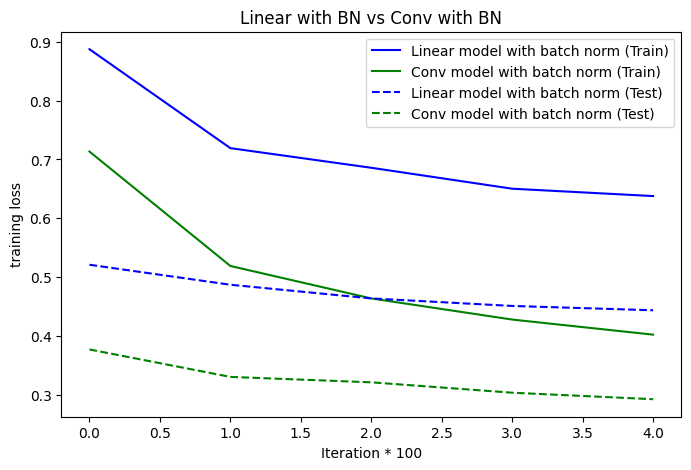

In [11]:
fig = plt.figure(figsize=(8,5))
plt.plot(x_vals, bn_ll_t_iter_losses, label="Linear model with batch norm (Train)", c="blue")
plt.plot(x_vals, bn_conv_t_iter_losses, label="Conv model with batch norm (Train)", c="green")

plt.plot(x_vals_test_data, bn_ll_e_iter_losses, label="Linear model with batch norm (Test)", linestyle="dashed", c="blue")
plt.plot(x_vals_test_data, bn_conv_e_iter_losses, label="Conv model with batch norm (Test)", linestyle="dashed", c="green")

plt.xlabel('Iteration * 100')
plt.ylabel('training loss')
plt.title("Linear with BN vs Conv with BN")
plt.legend()
plt.show()
plt.close()

### Convolutional model with batch norm performs better than linear model with batch norm for classifying FashionMNIST dataset.